# Generative Adversarial Network

Reference: https://github.com/eriklindernoren/Keras-GAN/

## Setting

Mount Google Drive

In [11]:
from google.colab import drive

mount_folder = '/content/gdrive'
drive.mount(mount_folder)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Go into the working directory

In [0]:
import os

app_folder = mount_folder + '/My Drive/'
os.chdir(app_folder)

Input

In [0]:
from pathlib import Path

def get_banner_folder(prefixe = 'original'):
  banner_folder = 'data/'+prefixe+'_steam_banners/'
  Path(banner_folder).mkdir(exist_ok=True)  
  return banner_folder

def get_file_extension():
  return '.jpg'
  
def get_banner_file_name(app_id):
  return get_banner_folder() + str(app_id) + get_file_extension()

Banners which are a black background

In [0]:
def get_skipped_banners():
  skipped_app_ids = [396540]
  skipped_banners = [get_banner_folder() + str(app_id) + get_file_extension() for app_id in skipped_app_ids]
  return skipped_banners

## Pre-processing

Aggregate Steam banners, resized to 56x56 grayscale images, into a NumPy structure for faster processing

In [0]:
import glob
import numpy as np

from time import time

from keras.preprocessing.image import load_img

def get_matrix_file_name():
  return 'data/banner_matrix.npy'


def prepare_data_matrix(img_rows=56, img_cols=56, channels=1, prefixe = 'original', reset_matrix=False):     
  all_image_names = glob.glob(get_banner_folder(prefixe) + '*' + get_file_extension())  
  
  # There is an issue with duplicates, e.g. 'ABC (1).jpg' but only when running on Google Drive:
  image_names = [img for img in all_image_names if ' (' not in img]
  
  num_samples = len(image_names)
    
  if reset_matrix:
    X_train = np.zeros((num_samples, img_rows, img_cols, channels))    
  else:
    try:
      X_train = np.load(get_matrix_file_name())
    except FileNotFoundError:
      X_train = np.zeros((num_samples, img_rows, img_cols, channels))    
    
  has_changed = False
  start = time()
  
  for counter, image_name in enumerate(sorted(image_names)):    
    
    if np.any(X_train[counter,...]!=0) or (image_name in get_skipped_banners()):
      continue
    
    if (counter+1) % 100 == 0:
      print('Elapsed time: {:.2f} s'.format(time() - start))
      start = time()      
      print('Iteration {}/{}'.format(counter+1, num_samples))
      if has_changed:
        np.save(get_matrix_file_name(), X_train)
        has_changed = False        

    image = load_img(image_name, target_size=(img_rows, img_cols))    
    has_changed = True
    
    # Grayscale
    if channels==1:
      image = np.expand_dims(np.mean(image, axis=2), axis=2)

    X_train[counter, ...] = image    
  
  if has_changed:
    print('Saving.')
    np.save(get_matrix_file_name(), X_train)
  
  return X_train

Using TensorFlow backend.


Choose image size and the number of channels (color vs. grayscale image):

In [0]:
img_rows=11
img_cols=23
channels=3

In [0]:
X_train = prepare_data_matrix(img_rows=img_rows, img_cols=img_cols, channels=channels, prefixe='original', reset_matrix=False)  

Load pre-computed aggregate of resized Steam banners

In [0]:
X_train = np.load(get_matrix_file_name())

X_train.shape

(31718, 11, 23, 3)

Display Steam banners of real games

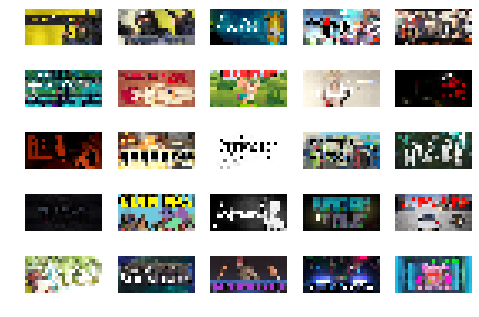

In [0]:
import matplotlib.pyplot as plt

r = 5
c = 5

num_channels = X_train.shape[-1]

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        if num_channels > 1:
          image = np.array(X_train[cnt, ...])
        else:
          image = 255 - np.array(X_train[cnt, :, :, 0])
        # Reference: https://stackoverflow.com/a/51255361
        axs[i,j].imshow(image.astype(np.uint8))
        axs[i,j].axis('off')
        cnt += 1
plt.show()        

## Train GAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class GAN():
    # CODE CHANGED BELOW
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_gan/'
        Path(self.image_folder).mkdir(exist_ok=True)             
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name())
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
              # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])                    
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()

In [0]:
gan = GAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 759)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               389120    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 520,705
Trainable params: 520,705
Non-trainable params: 0
_________________________________________________________________
____

In [0]:
gan.train(epochs=30000, batch_size=32, sample_interval=200)

Display sampled banners

(-0.5, 575.5, 395.5, -0.5)

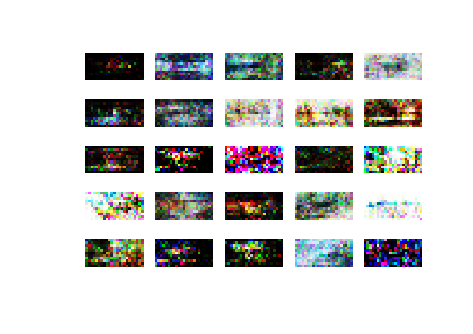

In [0]:
plt.imshow(plt.imread(gan.image_folder + '29800.png'))
plt.axis('off')

## Train WGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class WGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_wgan/'
        Path(self.image_folder).mkdir(exist_ok=True)                
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Flatten())
        model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        model.add(Reshape(self.img_shape))      

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name())
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # CODE CHANGED BELOW
        if self.channels == 1:        
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)
                
                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % 100 == 0:
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [0]:
wgan = WGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 6, 12, 16)         448       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6, 12, 16)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 12, 16)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 6, 32)          4640      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 4, 7, 32)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 7, 32)          0         
__________

In [0]:
wgan.train(epochs=4000, batch_size=32, sample_interval=50)

Display sampled banners

(-0.5, 575.5, 395.5, -0.5)

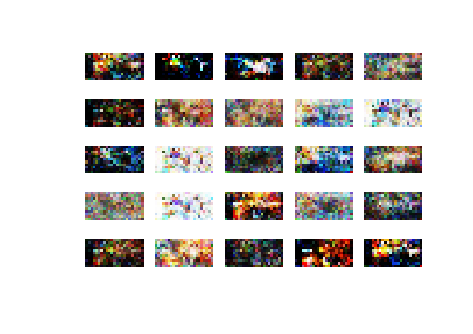

In [0]:
plt.imshow(plt.imread(wgan.image_folder + '3950.png'))
plt.axis('off')

## Train DCGAN

Reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

Import Python modules

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [0]:
class DCGAN():
    # CODE CHANGED BELOW  
    def __init__(self, img_rows=11, img_cols=23, channels=3):
        # Input shape      
        self.img_rows = img_rows # 215
        self.img_cols = img_cols # 460
        self.channels = channels # 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        # CODE CHANGED BELOW  
        self.image_folder = 'images_steam_dcgan/'
        Path(self.image_folder).mkdir(exist_ok=True)                
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Flatten())
        model.add(Dense(np.prod(self.img_shape)))
        model.add(Activation('tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        # CODE CHANGED BELOW
        X_train = np.load(get_matrix_file_name())
        if self.channels == 1:
          X_train = np.mean(X_train, axis=3)
       
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # CODE CHANGED BELOW
        if self.channels == 1:                
          X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % 100 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                # CODE CHANGED BELOW
                if gen_imgs.shape[-1]>1:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                else:
                  axs[i,j].imshow(gen_imgs[cnt, :,:,0]) 
                axs[i,j].axis('off')
                cnt += 1
        # CODE CHANGED BELOW                
        fig.savefig(self.image_folder + "%d.png" % epoch)
        plt.close()


In [0]:
dcgan = DCGAN(img_rows=img_rows, img_cols=img_cols, channels=channels)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 12, 32)         896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 12, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 12, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 6, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 4, 7, 64)          0         
_________________________________________________________________
batch_normalization_1

In [0]:
dcgan.train(epochs=4000, batch_size=32, save_interval=50)

Display sampled banners

(-0.5, 575.5, 395.5, -0.5)

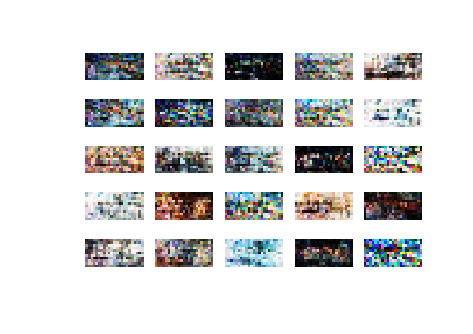

In [0]:
plt.imshow(plt.imread(dcgan.image_folder + '3950.png'))
plt.axis('off')